In [1]:
#The goal is to go beyond regex of useful substrings from each entry, and to perform topological analysis of address construction
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
file = 'NonStdAdd.tsv'
df=pd.read_table(file)
df.insert(0,'id',range(1,len(df)+1))
df.fillna("", inplace=True)
df.iloc[[442]]

,id,Address,Count
442,443,,20


In [3]:
#replace commas with spaces
translator = str.maketrans(',',' '*len(' '))
#split addresses into bags of words
baglist = df['Address'].apply(lambda address: [word for word in address.translate(translator).split()])
#flatten wordlist of bags
wordlist = [word for bag in baglist for word in bag]
#convert flattened Series to DataFrame
wordlist = pd.Series(wordlist).to_frame()
#name column
wordlist.rename(columns={list(wordlist)[0]:'word'}, inplace=True)
#create column to store groupby().count() 
wordlist['wordcount'] = pd.Series(1, index=wordlist.index)
print(type(wordlist))
print(type(wordlist['word']))
print(wordlist.head())

print(wordlist[wordlist.word == ''])
print(wordlist[wordlist.word == ''].count()) #no more empty lines after applying translate(), not sure why
len(wordlist)
print(type(wordlist.wordcount))
print(type(wordlist.wordcount[0]))
print(type(wordlist.count)) #'count' is a reserved keyword for a dataframe method, don't use it to name a column

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
        word  wordcount
0        YIO          1
1        CHU          1
2       KANG          1
3       ROAD          1
4  SINGAPORE          1
Empty DataFrame
Columns: [word, wordcount]
Index: []
word         0
wordcount    0
dtype: int64
<class 'pandas.core.series.Series'>
<class 'numpy.int64'>
<class 'method'>


In [4]:
wordlisttopo = wordlist.groupby('word').count()
#wordlisttopo = wordlist\
#    .groupby(wordlist.word)\
#    .agg({
#        'count': 'count'
#    })
#number of different words in sample
print(len(wordlisttopo))
wordlisttopo.insert(0,'wordliteral',wordlisttopo.index.to_series())
#store length of each word from sample into new column
wordlisttopo['len'] = [len(word) for word in wordlisttopo.index.to_series()]
wordlisttopo.sort_values(['len','wordliteral'],ascending=[True,True],inplace=True)
print(wordlisttopo.head())
print(type(wordlist.wordcount[0]))
print(len(wordlisttopo[wordlisttopo.wordcount != 1]))
print(wordlisttopo[wordlisttopo.wordcount != 1])

2315
     wordliteral  wordcount  len
word                            
#              #          1    1
&              &         80    1
(              (          2    1
-              -         32    1
/              /         48    1
<class 'numpy.int64'>
468
                         wordliteral  wordcount  len
word                                                
&                                  &         80    1
(                                  (          2    1
-                                  -         32    1
/                                  /         48    1
0                                  0         62    1
1                                  1         53    1
2                                  2         23    1
3                                  3         30    1
4                                  4         31    1
5                                  5         22    1
6                                  6         21    1
7                                  7         17  

In [5]:
def wordform(word):
    form = ''
    for char in word:
        f = ''
        if char.isdigit():
            f += 'n'
        if char.isalpha():
            f += 'c'
        if char == '':
            f += '<emptystring>'
            
        if len(f) == 0:
            f += 's'
        if len(f) > 1:
            raise ValueError('Character detected should not be classified as more than one type from: numeric, character, emptystring, other')
        form += f
    return form

In [6]:
#generate wordform column
wordlisttopo['wordform'] = [wordform(word) for word in wordlisttopo.index.to_series()]
wordlisttopo.sort_values(['len','wordform'],ascending=[True,True],inplace=True)
print(wordlisttopo[wordlisttopo.wordcount > 1].iloc[:30, 1:4]) #slice out last 10 rows, columns 1 to 4, 4 exclusive
#print(wordlisttopo[wordlisttopo.len == 1])

      wordcount  len wordform
word                         
K             2    1        c
T             2    1        c
0            62    1        n
1            53    1        n
2            23    1        n
3            30    1        n
4            31    1        n
5            22    1        n
6            21    1        n
7            17    1        n
8            19    1        n
9            14    1        n
&            80    1        s
(             2    1        s
-            32    1        s
/            48    1        s
:            11    1        s
@            13    1        s
AT          367    2       cc
IN            4    2       cc
MK           25    2       cc
MO           13    2       cc
NO           11    2       cc
OF           26    2       cc
ON            9    2       cc
PT          149    2       cc
RD            8    2       cc
ST           10    2       cc
TO            8    2       cc
TS            6    2       cc


In [7]:
wordformtopo = wordlisttopo.groupby('wordform')['wordcount'].sum().to_frame()
wordformtopo.rename(columns={list(wordformtopo)[0]:'formcount'}, inplace=True)
#number of different wordforms
print(len(wordformtopo))
wordformtopo.insert(0,'wordform-literal',wordformtopo.index.to_series())
wordformtopo['len'] = [len(word) for word in wordformtopo.index.to_series()]
#wordformtopo.sort_values(['len','wordform-literal'],ascending=[True,True],inplace=True)
wordformtopo.sort_values(['formcount'],ascending=[False],inplace=True)
print(wordformtopo)

186
                      wordform-literal  formcount  len
wordform                                              
cccc                              cccc        736    4
cc                                  cc        646    2
ccc                                ccc        540    3
ccccc                            ccccc        529    5
cccccc                          cccccc        470    6
ccnnsnnnnnc                ccnnsnnnnnc        447   11
cccccccc                      cccccccc        394    8
nn                                  nn        383    2
ccccccccc                    ccccccccc        375    9
ccccccc                        ccccccc        303    7
n                                    n        292    1
nnnnnn                          nnnnnn        239    6
ccs                                ccs        229    3
s                                    s        187    1
nnnnnc                          nnnnnc        183    6
cccs                              cccs        152    4
csnnns

In [8]:
#the wordforms constitute columns, binary presence of a wordform in an address is a feature. Cluster by these 186 features.

#define vectorizer params for word-literal vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.7, max_features=3000, min_df=0.1, \
                                           stop_words='english', use_idf=True, tokenizer=None, ngram_range=(1,4))

In [9]:
#list of addresses as string literals
add_lits_tokenized = baglist.tolist()
add_lits = df['Address'].tolist()
#print(add_lits[:10])
add_wordforms_tokenized = df['Address'].apply(lambda address: [wordform(word) for word in address.split()]).tolist()
#list of addresses as string literals
add_wordforms = [' '.join(wordform_list) for wordform_list in add_wordforms_tokenized]
print(add_lits[:10])
print(add_wordforms[:10])
print(add_lits_tokenized[:10])
print(add_wordforms_tokenized[:10])

['YIO CHU KANG ROAD SINGAPORE 540000', 'WOODLEIGH CLOSE LOT 7459 MK 17 SINGAPORE 350000', 'TUAS SOUTH AVENUE 2/5 MK 7 ON LOTS 2843LPT,2652CPT & 2846WPT SINGAPORE 630000', 'TUAS SOUTH AVE 5, 7 & 8 LOT NO. 2495P MK 7 SINGAPORE 630000', 'TUAS SOUTH AVE 1, 2 & 3 LOT 3103M MK 7 SINGAPORE 630000', 'TS15-00609T VICTORIA STREET', 'SENGKANG TOWN NEIGHBOURHOOD 2 CONTRACT 37 SINGAPORE 540000', 'S.L. LOT 4150PT LOYANG WAY NEAR LP 89 SINGAPORE 500000', 'PUNGGOL ROAD, (PUNGGOL EAST C19), (CONTRACT NO: D/163/08), SINGAPORE 540000', 'PUNGGOL EAST CONTRACT 18 CONTRACT NO: D/077/08 SINGAPORE 820000']
['ccc ccc cccc cccc ccccccccc nnnnnn', 'ccccccccc ccccc ccc nnnn cc nn ccccccccc nnnnnn', 'cccc ccccc cccccc nsn cc n cc cccc nnnncccsnnnnccc s nnnnccc ccccccccc nnnnnn', 'cccc ccccc ccc ns n s n ccc ccs nnnnc cc n ccccccccc nnnnnn', 'cccc ccccc ccc ns n s n ccc nnnnc cc n ccccccccc nnnnnn', 'ccnnsnnnnnc cccccccc cccccc', 'cccccccc cccc ccccccccccccc n cccccccc nn ccccccccc nnnnnn', 'cscs ccc nnnncc cccccc 

In [10]:
al_tfidf_matrix = tfidf_vectorizer.fit_transform(add_lits)
print(type(al_tfidf_matrix))
print(al_tfidf_matrix.shape)
wf_tfidf_matrix = tfidf_vectorizer.fit_transform(add_wordforms)
print(wf_tfidf_matrix.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(700, 8)
(700, 27)


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
al_dist = 1 - cosine_similarity(al_tfidf_matrix)
wf_dist = 1 - cosine_similarity(wf_tfidf_matrix)

print(type(al_dist))
print(al_dist[:10])

<class 'numpy.ndarray'>
[[  0.00000000e+00   6.47926209e-01   6.80408818e-01 ...,   1.00000000e+00
    1.00000000e+00   2.60667877e-01]
 [  6.47926209e-01   0.00000000e+00   4.05444340e-01 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  6.80408818e-01   4.05444340e-01  -2.22044605e-16 ...,   5.01558740e-01
    1.00000000e+00   1.00000000e+00]
 ..., 
 [  5.52292900e-01   2.13606862e-01   6.84413268e-01 ...,   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  2.52554795e-01   7.36844133e-01   7.61123104e-01 ...,   5.49308894e-01
    1.00000000e+00   4.47389750e-01]
 [  7.61480233e-01   8.14779932e-01   8.31868483e-01 ...,   3.65569627e-01
    1.00000000e+00   1.00000000e+00]]


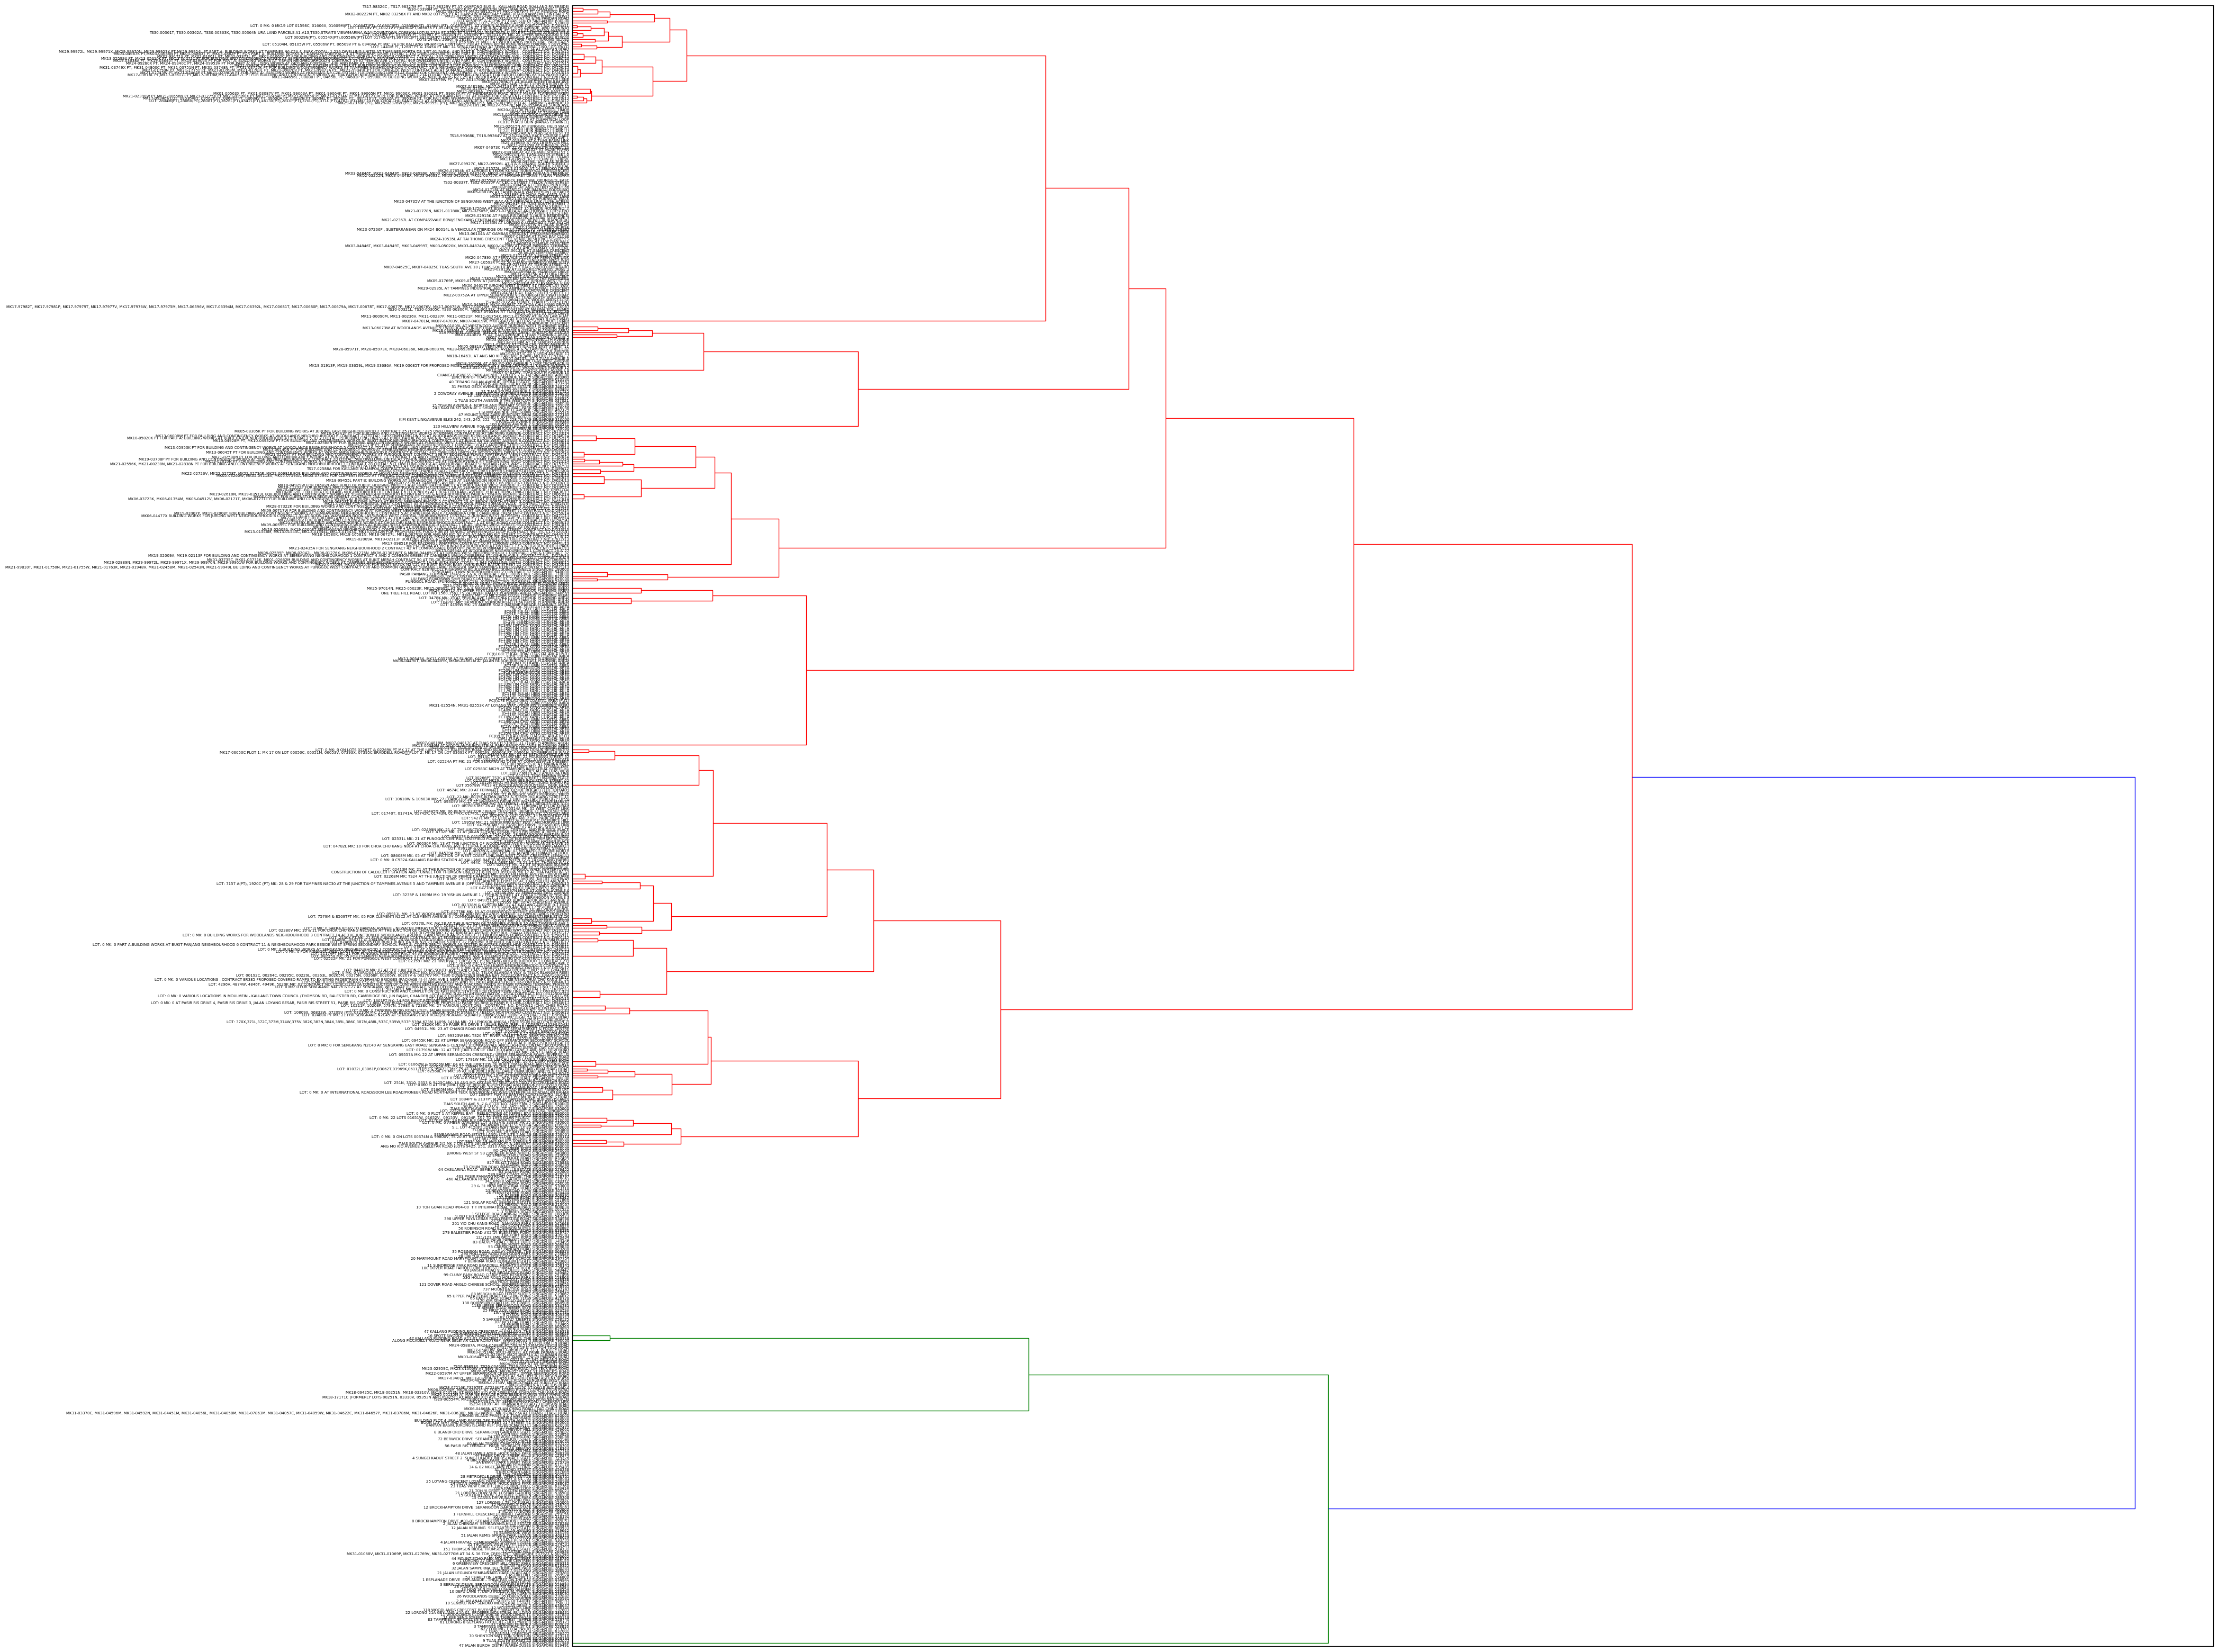

In [15]:
from scipy.cluster.hierarchy import ward, dendrogram

al_linkage_matrix = ward(al_dist)

al_fig, al_ax = plt.subplots(figsize=(40, 40)) # set size
al_ax = dendrogram(al_linkage_matrix, orientation="right", labels=add_lits);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

#plt.tight_layout() #show plot with tight layout
#uncomment below to save figure
plt.savefig('al_clusters.png', dpi=200) #save figure as ward_clusters

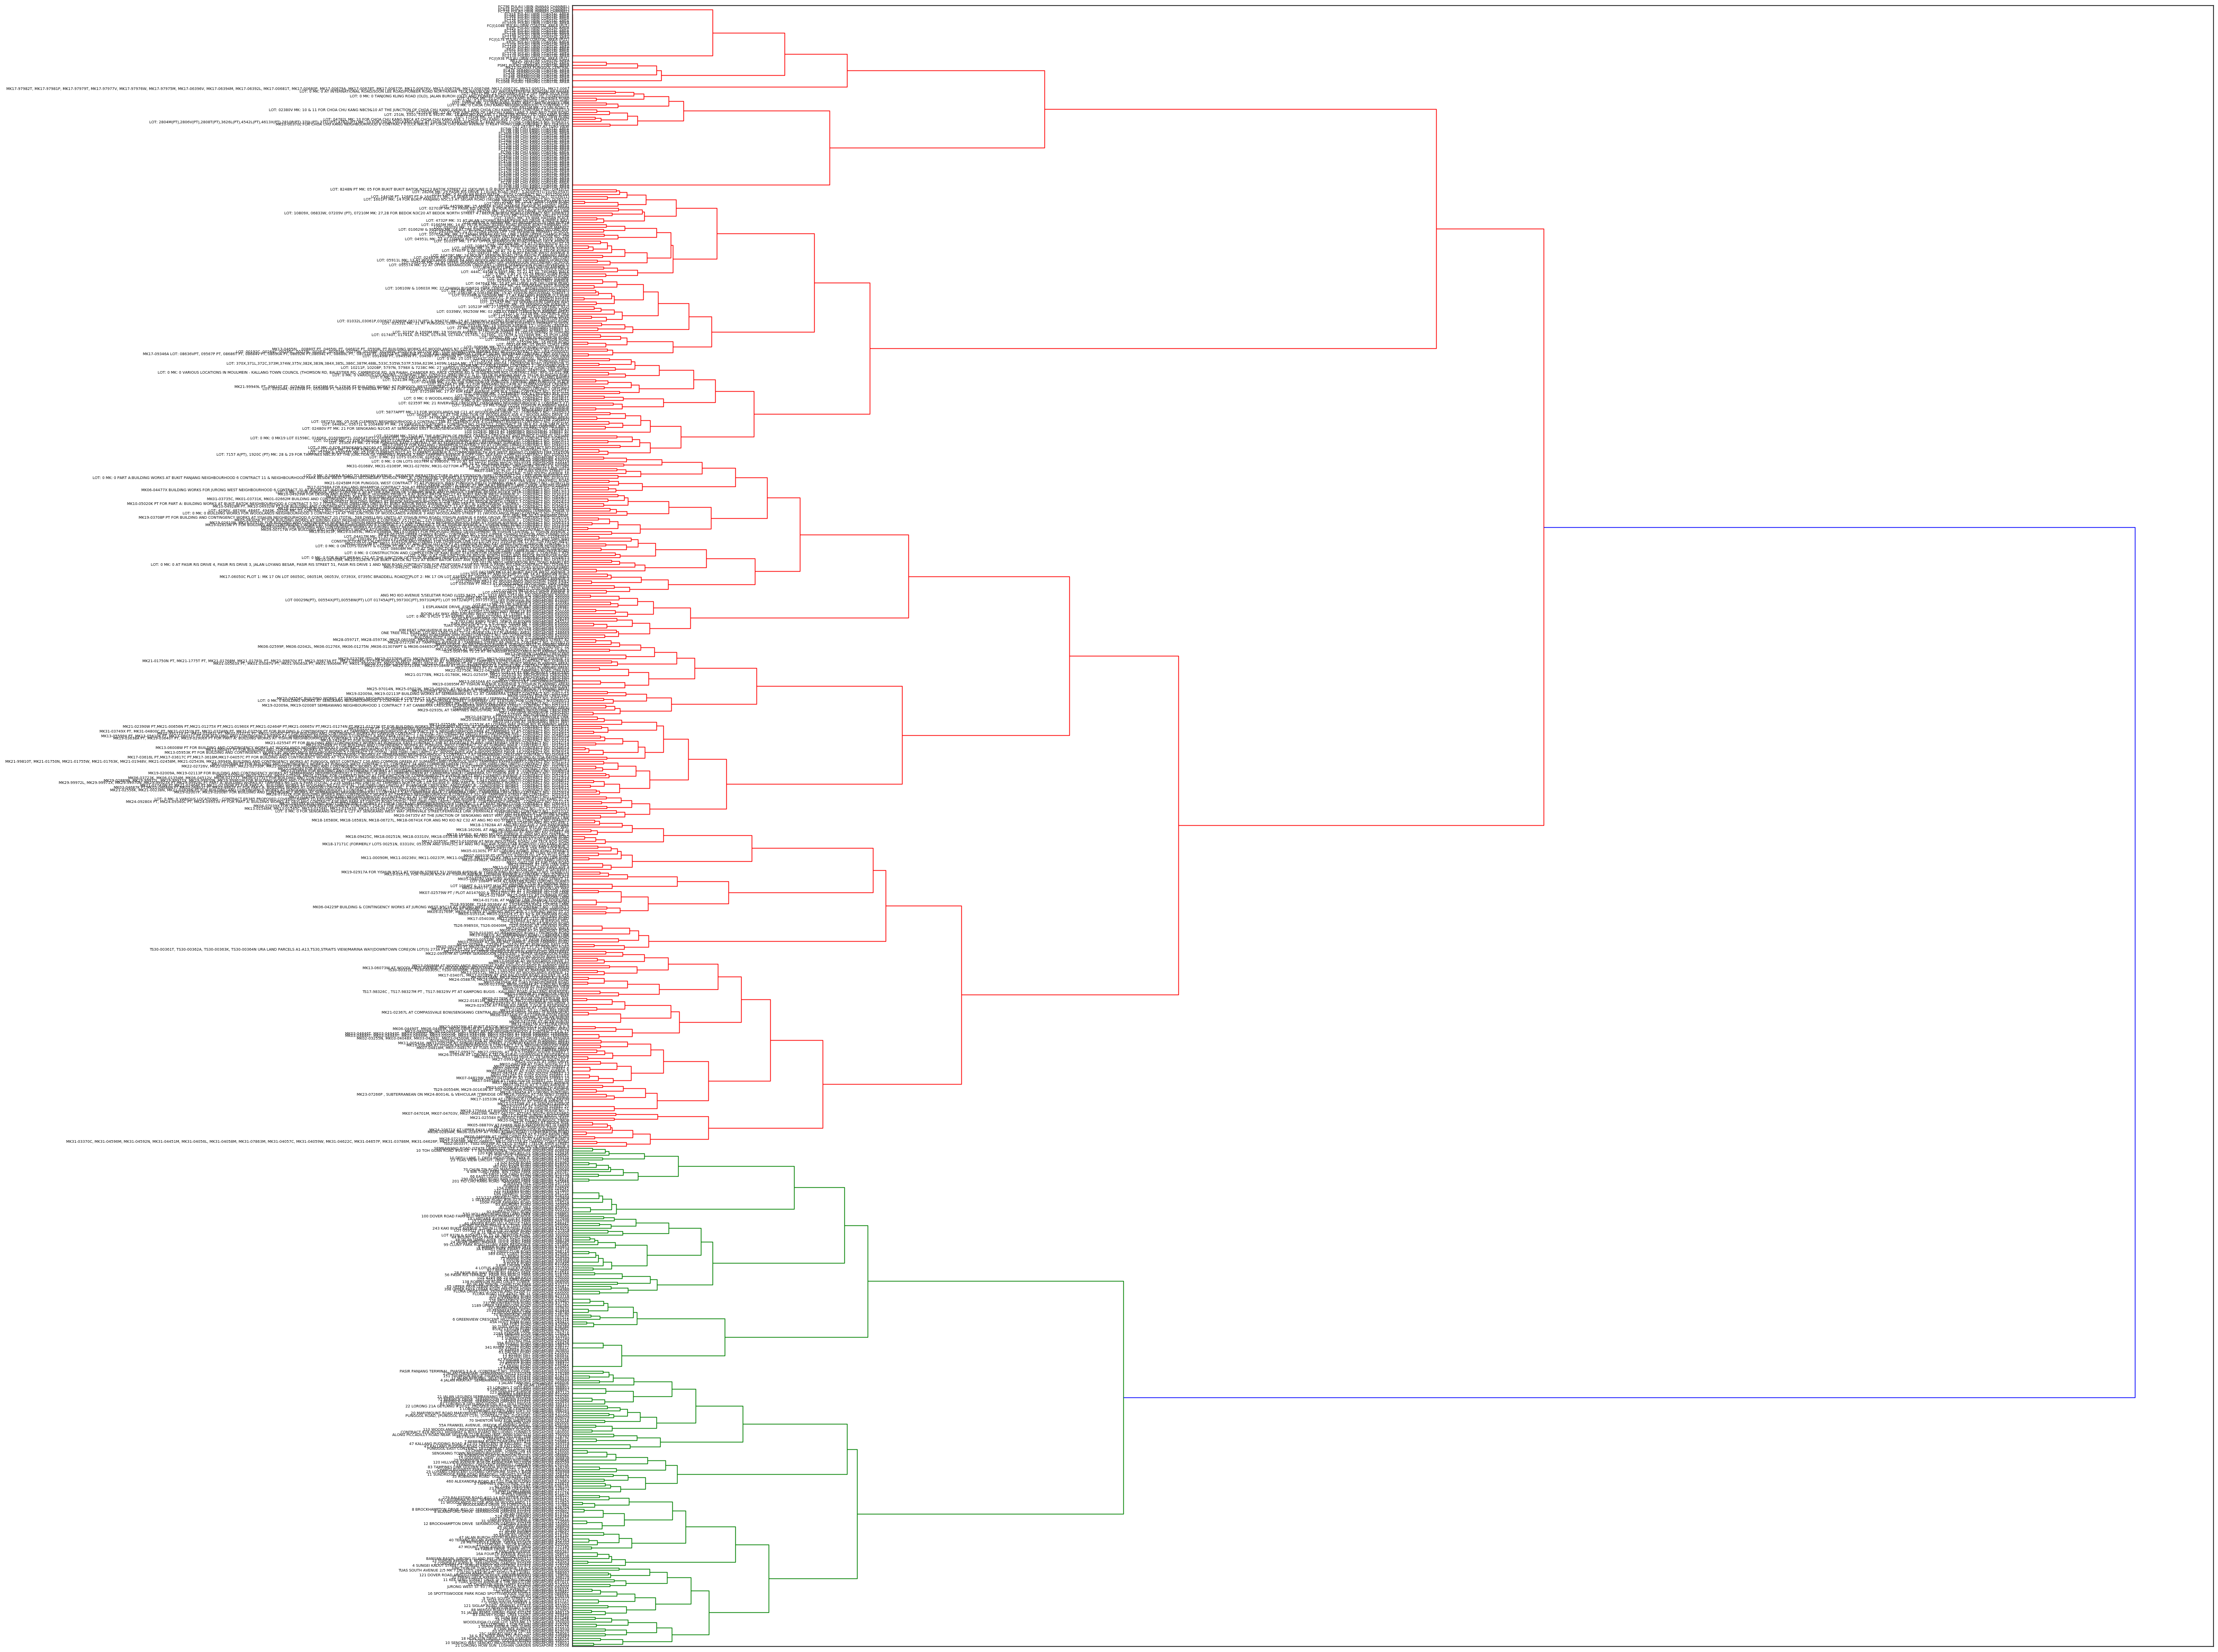

In [16]:
wf_linkage_matrix = ward(wf_dist)

wf_fig, wf_ax = plt.subplots(figsize=(40, 40)) # set size
wf_ax = dendrogram(wf_linkage_matrix, orientation="right", labels=add_lits);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

#plt.tight_layout() #show plot with tight layout
#uncomment below to save figure
plt.savefig('wf_clusters.png', dpi=200) #save figure as ward_clusters